# Sheet 1

**Link to the dataset**: https://www.kaggle.com/datasets/alphiree/cardiovascular-diseases-risk-prediction-dataset

# Pre-processing (same as part 1):

In [604]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

df2 = pd.read_csv('/data/notebook_files/CVD_cleaned.csv')
# Binary columns transformation

df2['Heart_Disease'] = df2['Heart_Disease'].map({'Yes': 1, 'No': 0})
df2['Sex'] = df2['Sex'].map({'Female': 1, 'Male': 0})
# Dropping columns we don't need

df2.drop(columns=['General_Health', 'Checkup', 'Exercise', 'Skin_Cancer', 'Other_Cancer', 'Depression', 'Diabetes',
                  'Arthritis', 'Smoking_History', 'Fruit_Consumption', 'Green_Vegetables_Consumption',
                  'FriedPotato_Consumption', 'Weight_(kg)', 'Height_(cm)'], inplace=True)
df2.head()

,Heart_Disease,Sex,Age_Category,BMI,Alcohol_Consumption
0,0,1,70-74,14.54,0.0
1,1,1,70-74,28.29,0.0
2,0,1,60-64,33.47,4.0
3,1,0,75-79,28.73,0.0
4,0,0,80+,24.37,0.0


In [605]:
print(df2.columns.tolist())

['Heart_Disease', 'Sex', 'Age_Category', 'BMI', 'Alcohol_Consumption']


# PART 1

Our research question is: What is the effect of alcohol consumption, sex, and having heart disease on BMI?

In [606]:
df = df2.copy()
x_list = ['Heart_Disease', 'Sex', 'Alcohol_Consumption']
y_title = 'BMI'

independent_vars = x_list

n = 200
k = len(x_list)
p = k + 1
B = 400

np.random.seed(100)
df_sampled = df.sample(200)

## Q1

In [607]:
# Initialize the design matrix and outcome vector for regression analysis.

predictors = df[x_list].to_numpy() 
outcome = df[y_title].to_numpy()  
design_matrix = np.c_[np.ones(predictors.shape[0]), predictors]

# Compute the transposed product of the design matrix.
transposed_product = np.dot(design_matrix.T, design_matrix)

# Calculate the inverse of the transposed product matrix.
inverse_matrix = np.linalg.inv(transposed_product)  

# Determine the product of transposed design matrix and outcome vector.
design_outcome_product = np.dot(design_matrix.T, outcome)  

# Estimate regression coefficients using Ordinary Least Squares (OLS).
beta_estimates = np.dot(inverse_matrix, design_outcome_product) 

### א

In [608]:
# Set up the matrix of predictors and the response variable for confidence interval computation.
design_matrix = df[x_list].to_numpy()
outcome_vector = df[y_title].to_numpy()
extended_matrix = np.c_[np.ones(design_matrix.shape[0]), design_matrix]
matrix_product = np.dot(extended_matrix.T, extended_matrix)
inverted_matrix = np.linalg.inv(matrix_product)
outcome_product = np.dot(extended_matrix.T, outcome_vector)

parameter_estimates = np.dot(inverted_matrix, outcome_product)
covariance_matrix = np.linalg.inv(extended_matrix.T @ extended_matrix)
deviations = outcome_vector - np.dot(extended_matrix, beta_estimates)
variance_estimation = 1 / (200 - (len(x_list) + 1)) * np.sum(deviations ** 2)
z_value = stats.norm.ppf(0.975)
intervals_of_confidence = []

# Calculate and print the confidence intervals for each parameter.
for index, predictor in enumerate(['Intercept'] + x_list):
    variance_of_coeff = variance_estimation * covariance_matrix[index][index]
    std_error_coeff = np.sqrt(variance_of_coeff)
    interval = [beta_estimates[index] - z_value * std_error_coeff, 
                beta_estimates[index] + z_value * std_error_coeff]
    intervals_of_confidence.append(interval)
    print(f"Confidence Interval for parameter {index} ({predictor}): {interval}")
    print(f"Is the population parameter estimate within the interval? {'Yes' if parameter_estimates[index] >= interval[0] and parameter_estimates[index] <= interval[1] else 'No'}")
    print()

parameter_estimates

Confidence Interval for parameter 0 (Intercept): [27.630042575036622, 30.678538093849756]
Is the population parameter estimate within the interval? Yes

Confidence Interval for parameter 1 (Heart_Disease): [-2.4535652785965794, 4.223945120831681]
Is the population parameter estimate within the interval? Yes

Confidence Interval for parameter 2 (Sex): [-2.13024017073798, 1.5413334600231223]
Is the population parameter estimate within the interval? Yes

Confidence Interval for parameter 3 (Alcohol_Consumption): [-0.19933711580122862, 0.023948944448405257]
Is the population parameter estimate within the interval? Yes



array([29.15429033, 0.88518992, -0.29445336, -0.08769409])

### ב

In [609]:
# Initialize lists to store bootstrap estimates for each coefficient.
intercept_coefficients = []
beta_1_coefficients = []
beta_2_coefficients = []
beta_3_coefficients = []

# Perform bootstrap sampling and estimation.
for iteration in range(B):
    bootstrap_sample = df.sample(n, replace=True)
    bootstrap_predictors = bootstrap_sample[x_list].to_numpy()
    bootstrap_predictors = np.c_[np.ones(bootstrap_predictors.shape[0]), bootstrap_predictors]
    bootstrap_response = bootstrap_sample[y_title].to_numpy()
    product_response_bootstrap = np.matmul(bootstrap_predictors.T, bootstrap_response)
    matrix_inverse_bootstrap = np.linalg.inv(bootstrap_predictors.T @ bootstrap_predictors)
    ols_estimator_bootstrap = np.matmul(matrix_inverse_bootstrap, product_response_bootstrap)
    intercept_coefficients.append(ols_estimator_bootstrap[0])
    beta_1_coefficients.append(ols_estimator_bootstrap[1])
    beta_2_coefficients.append(ols_estimator_bootstrap[2])
    beta_3_coefficients.append(ols_estimator_bootstrap[3])

# Calculate standard errors for each coefficient based on bootstrap samples.
bootstrap_standard_errors = [np.std(intercept_coefficients), np.std(beta_1_coefficients), np.std(beta_2_coefficients), np.std(beta_3_coefficients)]

# Construct confidence intervals using the normal approximation from bootstrap standard errors.
bootstrap_confidence_intervals = []
for index, feature in enumerate(['Intercept'] + x_list):
    confidence_interval = [ols_estimator_bootstrap[index] - stats.norm.ppf(0.975) * bootstrap_standard_errors[index], 
                           ols_estimator_bootstrap[index] + stats.norm.ppf(0.975) * bootstrap_standard_errors[index]]
    bootstrap_confidence_intervals.append(confidence_interval)
    print(f"Confidence Interval for coefficient {index} ({feature}): {confidence_interval}")
    print(f"Does the interval include the population parameter estimate? {'Yes' if parameter_estimates[index] >= confidence_interval[0] and parameter_estimates[index] <= confidence_interval[1] else 'No'}\n")

Confidence Interval for coefficient 0 (Intercept): [27.34279304403355, 30.15876742190705]
Does the interval include the population parameter estimate? Yes

Confidence Interval for coefficient 1 (Heart_Disease): [-2.1608715034642607, 4.619618427871696]
Does the interval include the population parameter estimate? Yes

Confidence Interval for coefficient 2 (Sex): [-2.0476598742844754, 1.7837502765907092]
Does the interval include the population parameter estimate? Yes

Confidence Interval for coefficient 3 (Alcohol_Consumption): [-0.16185897007837038, 0.024103391389495493]
Does the interval include the population parameter estimate? Yes



### ג

In [610]:
# Initialize a dictionary to store quantiles of bootstrap estimates.
bootstrap_quantiles = {}

# Define the names for the coefficients
coefficient_names = ['intercept', 'beta_1', 'beta_2', 'beta_3']
coefs = [intercept_coefficients, beta_1_coefficients, beta_2_coefficients, beta_3_coefficients]

# Calculate the 2.5th and 97.5th percentiles for each bootstrap coefficient distribution.
for name, coef in zip(coefficient_names, coefs):
    bootstrap_quantiles[name] = (np.quantile(coef, 0.975), np.quantile(coef, 0.025))

# Compute the pivotal confidence intervals.
pivotal_intervals = []
for index, (predictor, name) in enumerate(zip(['Intercept'] + x_list, coefficient_names)):
    interval = [2 * parameter_estimates[index] - bootstrap_quantiles[name][0], 
                2 * parameter_estimates[index] - bootstrap_quantiles[name][1]]
    pivotal_intervals.append(interval)
    print(f"Confidence Interval for {predictor} (coefficient {index}): {interval}")
    print(f"Does the interval include the population parameter estimate? {'Yes' if parameter_estimates[index] >= interval[0] and parameter_estimates[index] <= interval[1] else 'No'}\n")

Confidence Interval for Intercept (coefficient 0): [27.696188919065694, 30.4554255500578]
Does the interval include the population parameter estimate? Yes

Confidence Interval for Heart_Disease (coefficient 1): [-2.980020020793149, 4.023494601061506]
Does the interval include the population parameter estimate? Yes

Confidence Interval for Sex (coefficient 2): [-2.102183833185758, 1.7183752286380867]
Does the interval include the population parameter estimate? Yes

Confidence Interval for Alcohol_Consumption (coefficient 3): [-0.1836248056560948, 0.008100798493758415]
Does the interval include the population parameter estimate? Yes



### ד

In [611]:
# Construct confidence intervals using the quantiles method from bootstrap samples.
quantiles_intervals = []
# Define the names for the coefficients as before
coefficient_names = ['intercept', 'beta_1', 'beta_2', 'beta_3']

for index, (predictor, name) in enumerate(zip(['Intercept'] + x_list, coefficient_names)):
    interval = [bootstrap_quantiles[name][1], bootstrap_quantiles[name][0]]
    quantiles_intervals.append(interval)
    print(f"Confidence Interval for {predictor} (coefficient {index}): {interval}")
    print(f"Does the interval include the population parameter estimate? {'Yes' if parameter_estimates[index] >= interval[0] and parameter_estimates[index] <= interval[1] else 'No'}\n")

Confidence Interval for Intercept (coefficient 0): [27.853155118828578, 30.612391749820684]
Does the interval include the population parameter estimate? Yes

Confidence Interval for Heart_Disease (coefficient 1): [-2.253114758826404, 4.7503998630282505]
Does the interval include the population parameter estimate? Yes

Confidence Interval for Sex (coefficient 2): [-2.307281939352944, 1.5132771224709003]
Does the interval include the population parameter estimate? Yes

Confidence Interval for Alcohol_Consumption (coefficient 3): [-0.18348896984658178, 0.008236634303271434]
Does the interval include the population parameter estimate? Yes



## Q2

In [612]:
# Initialize a dictionary to store the lengths of confidence intervals for each coefficient and method.
ci_lengths = {"coefficient": ["Intercept", "Heart_Disease", "Sex", "Alcohol_Consumption"],
              "normal_matrix": [],
              "normal_bootstrap": [],
              "pivot_bootstrap": [],
              "quantile_bootstrap": []}

# Calculate the lengths of the confidence intervals for each method and coefficient.
for idx in range(p):
    ci_lengths["normal_matrix"].append(round(intervals_of_confidence[idx][1] - intervals_of_confidence[idx][0], 4))
    ci_lengths["normal_bootstrap"].append(round(bootstrap_confidence_intervals[idx][1] - bootstrap_confidence_intervals[idx][0], 4))
    ci_lengths["pivot_bootstrap"].append(round(pivotal_intervals[idx][1] - pivotal_intervals[idx][0], 4))
    ci_lengths["quantile_bootstrap"].append(round(quantiles_intervals[idx][1] - quantiles_intervals[idx][0], 4))
   

# Convert the dictionary to a DataFrame and set the coefficient names as the index.
ci_lengths_df = pd.DataFrame(ci_lengths)
ci_lengths_df = ci_lengths_df.set_index("coefficient", drop=True)
ci_lengths_df

,normal_matrix,normal_bootstrap,pivot_bootstrap,quantile_bootstrap
coefficient,,,,
Intercept,3.0485,2.8160,2.7592,2.7592
Heart_Disease,6.6775,6.7805,7.0035,7.0035
Sex,3.6716,3.8314,3.8206,3.8206
Alcohol_Consumption,0.2233,0.1860,0.1917,0.1917


## Q3

### א

In [613]:
# Set the seed for reproducible random sampling.
np.random.seed(101)

# Merge the full dataframe with the sampled dataframe to identify rows not in the sample.
merged_data = df.merge(df_sampled, how='left', indicator=True)
unsampled_data = merged_data[merged_data["_merge"] == "left_only"]

# Randomly select 100 rows from the unsampled data.
new_sample = unsampled_data.sample(100).drop("_merge", axis=1)
new_sample

,Heart_Disease,Sex,Age_Category,BMI,Alcohol_Consumption
35594,0,0,25-29,24.03,4.0
265415,0,0,40-44,24.41,0.0
287574,0,0,35-39,26.63,0.0
293114,0,1,75-79,24.09,0.0
17671,0,0,55-59,33.96,1.0
...,...,...,...,...,...
258822,0,1,30-34,31.89,0.0
67832,0,0,18-24,28.12,0.0
172314,0,0,55-59,33.52,0.0
229195,0,0,75-79,25.10,28.0


In [614]:
# Prepare the design matrix for the new sample and the response variable.
predictors_new = new_sample[x_list].to_numpy()
predictors_new = np.c_[np.ones(predictors_new.shape[0]), predictors_new]
response_real = new_sample[y_title].to_numpy()

# Predict the response variable for the new sample using the OLS estimator from the sampled data.
predicted_response = np.dot(predictors_new, parameter_estimates)

### ב

In [615]:
# Initialize a list to store predicted responses from bootstrap samples.
bootstrap_predicted_responses = []

# Perform bootstrap sampling and prediction for the new sample.
for iteration in range(B):
    bootstrap_sample = df_sampled.sample(n, replace=True)
    bootstrap_predictors = bootstrap_sample[x_list].to_numpy()
    bootstrap_predictors = np.c_[np.ones(bootstrap_predictors.shape[0]), bootstrap_predictors]
    bootstrap_response = bootstrap_sample[y_title].to_numpy()
    product_response_bootstrap = np.dot(bootstrap_predictors.T, bootstrap_response)
    matrix_inverse_bootstrap = np.linalg.inv(bootstrap_predictors.T @ bootstrap_predictors)
    ols_estimator_bootstrap = np.dot(matrix_inverse_bootstrap, product_response_bootstrap)
    predicted_response_bootstrap = np.dot(predictors_new, ols_estimator_bootstrap)
    bootstrap_predicted_responses.append(predicted_response_bootstrap)



### ג

In [616]:
# Calculate the percentage of times the confidence interval contains the real response.
counter = 0
for i in range(len(predicted_response)):
    yi_se = np.std([y[i] for y in bootstrap_predicted_responses])
    yi_ci = [predicted_response[i] - z_value * yi_se, predicted_response[i] + z_value * yi_se]
    if response_real[i] >= yi_ci[0] and response_real[i] <= yi_ci[1]:
        counter += 1

print(f"Percentage: number of times C.I contained the real response: {counter / len(predicted_response) * 100}%")

Percentage: number of times C.I contained the real response: 23.0%


The observation that only 23% of the Confidence Intervals (CIs) include $Y_{\text{new}}$ might seem unusual at first, but it makes sense when you consider what these intervals represent. They're built around the expected value of the prediction, shown as $E(Y_{\text{new}} | X_{\text{new}})$, not the individual predictions themselves. Because these CIs focus on the average predicted value, they tend to be narrower. They don't account for the full range of possible outcomes for each prediction, which is why fewer of them contain the actual value of $Y_{\text{new}}$.

### ד

The variance of the new observations, which is denoted by $\sigma_{\epsilon}^2$, can be divided into two parts. The first part is the variance due to the input data, which we denote by $\sigma_{\epsilon}^2 X_{\text{new}} C X_{\text{new}}^T$. The second part is the inherent variance of the model, which is denoted by $\sigma_{\epsilon}^2$.

We'll adjust our computation by using the bootstrap method to estimate the variance of the residuals as before. However, the variance estimator for a new observation will now be calculated as follows:

${\hat{\sigma}^{*2}_{\epsilon} \cdot \mathbf{X}_{\text{new}}^\top \cdot \mathbf{C} \cdot \mathbf{X}_{\text{new}} + \hat{\sigma}^{*2}_{\epsilon}}$

Where ${\hat{\sigma}^{*2}}_{\epsilon}$ represents the bootstrap estimator for ${\sigma}^{*2}_{\epsilon}$.

# PART 2

## Q1
*Our original research question in Project p.2 was: Is there a difference in mean BMI between males and females?*

So this will be our research question for this part: **Is the distribution of BMI among males bigger than the distribution of BMI among females?**


## Q2

In [617]:
# q2
n = 200
np.random.seed(101)
df2_sampled = df2.sample(n)

## Q3

### א

In [618]:
# Q3.a index 1 refers to males, index to refers to females
males_df = df2_sampled[df2_sampled['Sex'] == 0]
females_df = df2_sampled[df2_sampled['Sex'] == 1]
n_males = len(males_df)
n_females = len(females_df)
mu_1 = males_df['BMI'].mean()
mu_2 = females_df['BMI'].mean()
delta = mu_1 - mu_2
print("Mean BMI of males: {}".format(mu_1))
print("Mean BMI of females: {}".format(mu_2))
print("mu_1 - mu_2 = {}".format(delta))

Mean BMI of males: 29.221368421052635
Mean BMI of females: 28.183238095238092
mu_1 - mu_2 = 1.0381303258145422


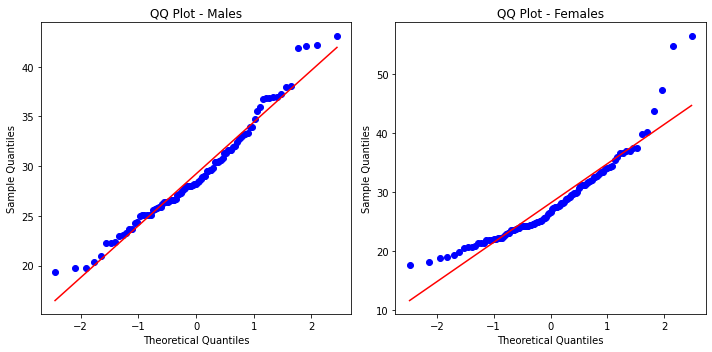

In [619]:
# Titles for the plots
titles = ["Males", "Females"]

# Set up the matplotlib figure with two subplots, one row and two columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for index, df in enumerate([males_df, females_df]):
    # Create a QQ plot in the appropriate subplot
    stats.probplot(df['BMI'], dist="norm", plot=axes[index])

    # Customize the plot with a conditional title
    axes[index].set_title(f"QQ Plot - {titles[index]}")
    axes[index].set_xlabel("Theoretical Quantiles")
    axes[index].set_ylabel("Sample Quantiles")

# Adjust the layout so the plots do not overlap
plt.tight_layout()

# Show the plots
plt.show()

The Q-Q plots suggest the data likely follows a Normal distribution, implying that the means are normally distributed. This indicates the mean is the maximum likelihood estimate (MLE). Furthermore, since the difference between MLEs is also an MLE, the delta value qualifies as an MLE too.

### ב

In [620]:
#3.b

alpha = 0.05
z_critical = stats.norm.ppf(1 - alpha / 2)
std_males = np.std(males_df['BMI'])
std_females = np.std(females_df['BMI'])
delta_var = std_males ** 2 + std_females ** 2
delta_std = np.sqrt(delta_var)
confidence_interval_difference = [delta - z_critical * (delta_std / np.sqrt(n)),
                                  delta + z_critical * (delta_std / np.sqrt(n))]
print(f"The CI for delta is: {confidence_interval_difference}")

The CI for delta is: [-0.16055325881576876, 2.2368139104448534]


### ג

In [621]:
#3.c
maled_df_all = df2[df2['Sex'] == 0]
femaled_df_all = df2[df2['Sex'] == 1]

mu_1_all = maled_df_all['BMI'].mean()
mu_2_all = femaled_df_all['BMI'].mean()
delta_all = mu_1_all - mu_2_all

is_in_CI = delta_all <= confidence_interval_difference[1] and delta_all >= confidence_interval_difference[0]
print(f"Delta estimator for the entire data: {delta_all}")
print(f"Is delta estimator for the entire data inside the CI for delta based on sample data? answer: {is_in_CI}")

Delta estimator for the entire data: 0.14344435649675447
Is delta estimator for the entire data inside the CI for delta based on sample data? answer: True


### ד

In [622]:
#3.d - wald test

# Compute the pooled variance of BMI for males and females
pooled_variance = (std_males ** 2 / n_males) + (std_females ** 2 / n_females)

# Calculate the standard error of the mean difference between male and female BMI
standard_error_difference = np.sqrt(pooled_variance)

# Define the null hypothesis value for the difference in means (no difference)
null_hypothesis_difference = 0

# Compute the test statistic for the difference in mean BMI between males and females
test_statistic = (delta - null_hypothesis_difference) / standard_error_difference

p_value_one_sided = stats.norm.cdf(-test_statistic)  # Adjusted for one-sided test

print("t-statistic:", test_statistic)
print("p-value:", p_value_one_sided)
print(f"Should we reject the null hypothesis? {p_value_one_sided < alpha}")

t-statistic: 1.2073810327928807
p-value: 0.11364271832328493
Should we reject the null hypothesis? False


In [623]:
# 3.d - permutations test  

import numpy as np
import random

# Observed difference in means (delta)
observed_difference = delta

# Number of permutations
num_permutations = 400

# Initialize a counter for permutations where the difference is greater or equal
counter = 0

# Combine all BMI values into a single array for resampling
all_BMI_values = np.concatenate([males_df['BMI'].values, females_df['BMI'].values])

# Perform the permutation test
for _ in range(num_permutations):
    # Shuffle the combined BMI randomly
    np.random.shuffle(all_BMI_values)

    # Split the shuffled BMI into two groups
    group1_BMIs = all_BMI_values[:n_males]
    group2_BMIs = all_BMI_values[n_males:]

    # Calculate the mean BMI for each group
    mu_group1 = np.mean(group1_BMIs)
    mu_group2 = np.mean(group2_BMIs)

    # Calculate the difference in means for this permutation
    permuted_difference = mu_group1 - mu_group2

    # Check if the permuted difference is greater or equal to the observed difference
    if permuted_difference >= observed_difference:
        counter += 1

# Calculate the p-value
p_value = counter / num_permutations

print("Permutation test:")
print(f"p-value: {p_value}")
print(f"Reject H0? {p_value < 0.05}")

Permutation test:
p-value: 0.1225
Reject H0? False


## Q4

### א

In [624]:
#Q4.a
# Calculate the median BMI for males (m_1)
m_1 = df2[df2['Sex'] == 0]['BMI'].median()

# Calculate the median BMI for females (m_2)
m_2 = df2[df2['Sex'] == 1]['BMI'].median()

# Calculate the difference between the two medians (delta)
delta_medians = m_1 - m_2

# Output the results
print(f"Median BMI for males (m_1): {m_1}")
print(f"Median BMI for females (m_2): {m_2}")
print(f"Difference in medians (delta): {delta_medians}")

Median BMI for males (m_1): 27.8
Median BMI for females (m_2): 27.37
Difference in medians (delta): 0.4299999999999997


We do not know how the median is distributed, so we cannot directly derive an MLE for it.

However, in Q3.a we saw (via QQ plots) that it is quite likely that our data is normally distributed. In a normal distribution, the mean and median are the same because of symmetricity. We also know that the mean is normally distributed, thanks to the Central Limit Theorem. Therefore, practically the sample median is a good estimator for the median, even though it's not an MLE in the traditional way.

### ב

The 95% confidence interval for the difference in medians is: [-1.2320000000000002, 1.2112499999999997]


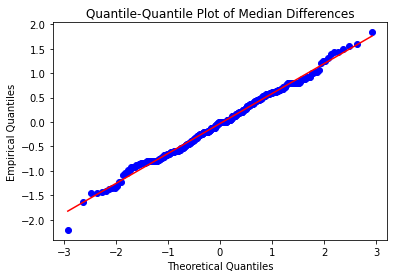

In [625]:
#Q4.b + d code

B = 400  # Number of permutations
delta_values = []

# Aggregating all BMI data into a unified array for further analysis
all_BMI_values = np.concatenate([males_df['BMI'].values, females_df['BMI'].values])

# Establishing the baseline difference in median BMIs
delta_est = delta_medians

# Initiating bootstrap analysis
for i in range(B):
    # Generate two new subsets by sampling without replacement
    group1_BMIs = np.random.choice(all_BMI_values, size=n_males, replace=False)
    group2_BMIs = np.random.choice(all_BMI_values, size=n_females, replace=False)

    # Compute the median BMI for each subgroup
    mu_group1 = np.median(group1_BMIs)
    mu_group2 = np.median(group2_BMIs)

    # Determine the median difference for this iteration
    delta_b = mu_group1 - mu_group2

    # Record the median difference
    delta_values.append(delta_b)

# Ordering the delta values
delta_values_sorted = np.sort(delta_values)

# Constructing the QQ plot to assess normality of the delta values
stats.probplot(delta_values_sorted, dist="norm", plot=plt)

# Configuring the plot's title and axes labels
plt.title('Quantile-Quantile Plot of Median Differences')  # Setting the plot title
plt.xlabel('Theoretical Quantiles')  # Naming the x-axis
plt.ylabel('Empirical Quantiles')  # Naming the y-axis
plt.show()

# Estimating the 95% confidence interval for the difference in medians
ci_lower = np.quantile(delta_values, alpha / 2)
ci_upper = np.quantile(delta_values, 1 - (alpha / 2))
print(f"The 95% confidence interval for the difference in medians is: [{ci_lower}, {ci_upper}]")




We used bootstrap to first check if we can assume that the delta of medians is normally distributed. The QQ plot indeed confirms this assumption. The CI (based on quantiles) for delta of medians is shown above the QQ plot.

### ג

In [626]:
males_all_median = np.median(maled_df_all['BMI'])
females_all_median = np.median(femaled_df_all['BMI'])
delta_medians_all = males_all_median - females_all_median
is_in_CI = delta_medians_all <= ci_upper and delta_medians_all >= ci_lower
print(f"Delta of medians estimator for full dataset: {delta_medians_all}")
print(f"Is Delta of medians estimator for full dataset in sample CI ? {is_in_CI}")

Delta of medians estimator for full dataset: 0.4299999999999997
Is Delta of medians estimator for full dataset in sample CI ? True


### ד

In [627]:
# Observed difference in means (delta)
observed_difference = delta_medians

# Combine all BMI values into a single array for resampling
all_BMI_values = np.concatenate([males_df['BMI'].values, females_df['BMI'].values])
counter = 0

# Perform the permutation test
for _ in range(B):
    # Shuffle the combined BMI randomly
    np.random.shuffle(all_BMI_values)

    # Split the shuffled BMI into two groups
    group1_BMIs = all_BMI_values[:n_males]
    group2_BMIs = all_BMI_values[n_males:]

    # Calculate the mean BMI for each group
    median_group1 = np.median(group1_BMIs)
    median_group2 = np.median(group2_BMIs)

    # Calculate the difference in means for this permutation
    permuted_difference = median_group1 - median_group2

    # Check if the permuted difference is greater or equal to the observed difference
    if permuted_difference >= observed_difference:
        counter += 1

# Calculate the p-value
p_value = counter / B

print("Permutation test:")
print(f"p-value: {p_value}")
print(f"Reject H0? {p_value < 0.05}")

Permutation test:
p-value: 0.3475
Reject H0? False


### ה

In [628]:
from scipy.stats import f

# Calculate the sample variances, not the squared standard errors
var_males = np.var(males_df['BMI'], ddof=1)
var_females = np.var(females_df['BMI'], ddof=1)
print(f"Sample variance of females = {var_females}, sample variance of males ={var_males}")
# Ensure the larger variance is in the numerator to avoid an F-statistic < 1
if var_males > var_females:
    f_statistic = var_males / var_females
    df_num = n_males - 1  # degrees of freedom for the numerator
    df_den = n_females - 1  # degrees of freedom for the denominator
else:
    f_statistic = var_females / var_males
    df_num = n_females - 1
    df_den = n_males - 1

p_value = 1 - f.cdf(f_statistic, df_num, df_den)  # n-1 DoF

print("F-statistic:", f_statistic)
print("p-value:", p_value)
print(f"Should we reject the null hypothesis? {p_value < alpha}")

Sample variance of females = 48.49444326007325, sample variance of males =27.059363001119827
F-statistic: 1.79215021647281
p-value: 0.0021567690781615356
Should we reject the null hypothesis? True


T-Test: Since we rejected the null hypothesis in the F test above, the assumption of equal variances does not hold, so we can't use T-test in Q4.d .

Wald test: We showed earlier that we can assume that the median is normally distributed, which means that we can use this test.

## Q5 

In [629]:
B = 400  # Number of permutations
counter = 0

# Combine all BMI values into a single array for resampling
all_BMI_values = np.concatenate([males_df['BMI'].values, females_df['BMI'].values])

# Rank the combined BMI values
ranks = np.argsort(np.argsort(all_BMI_values))

# Get the sum of ranks for the original groups
original_group1_ranks_sum = np.sum(ranks[:n_males])
original_group2_ranks_sum = np.sum(ranks[n_males:])

# Your observed difference in sum of ranks (delta)
delta_est = original_group1_ranks_sum - original_group2_ranks_sum

# Permutation test
for _ in range(B):
    # Randomly shuffle the ranks
    np.random.shuffle(ranks)

    # Get the sum of ranks for the permuted groups
    perm_group1_ranks_sum = np.sum(ranks[:n_males])
    perm_group2_ranks_sum = np.sum(ranks[n_males:])

    # Calculate the difference in sum of ranks for this permutation
    delta_b = perm_group1_ranks_sum - perm_group2_ranks_sum

    # Increment counter if permuted difference is greater than or equal to observed difference
    if (delta_b) >= (delta_est):
        counter += 1

# Calculate the p-value
p_value = counter / B
print(f"Original difference of ranks: {delta_est}")
print("Permutation test for delta of medians:")
print(f"p-value: {p_value}")
print(f"Should we reject H0? {p_value < 0.05}")

Original difference of ranks: 740
Permutation test for delta of medians:
p-value: 0.01
Should we reject H0? True


## Q6

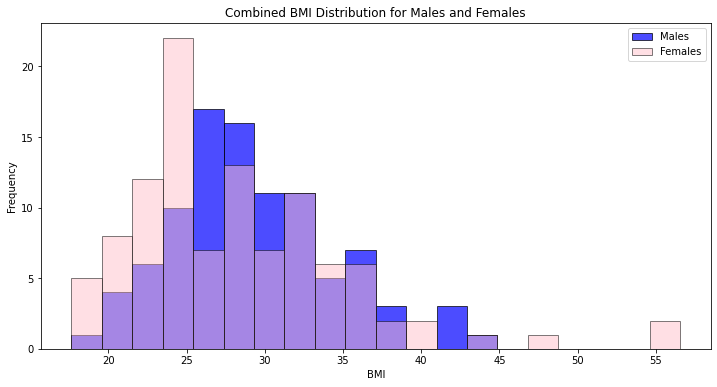

In [630]:
males_bmi = males_df['BMI'].values
females_bmi = females_df['BMI'].values

# Set up the matplotlib figure for the combined histogram
fig, ax = plt.subplots(figsize=(12, 6))

# Determine the common bin size for both groups
bins = np.histogram(np.hstack((males_bmi, females_bmi)), bins=20)[1]  # get the bin edges

# Plot histogram for males
ax.hist(males_bmi, bins=bins, color='blue', alpha=0.7, edgecolor='black', label='Males')

# Plot histogram for females
ax.hist(females_bmi, bins=bins, color='pink', alpha=0.5, edgecolor='black', label='Females')

# Create a legend to differentiate between males and females
ax.legend()

# Add titles and labels to the axes
ax.set_title('Combined BMI Distribution for Males and Females')
ax.set_xlabel('BMI')
ax.set_ylabel('Frequency')

# Show the combined histogram
plt.show()

Recap in part 2:

In Questions 3 to 5, we examined whether the BMI distributions of males and females are the same (null hypothesis H0), versus whether males have a generally higher BMI than females (alternative hypothesis H1).

In Q3, the permutation test on the difference in means did not lead us to reject the null hypothesis.

In Q4, similarly, the permutation test on the difference in medians did not convince us to reject the null hypothesis.

In Q5, however, we found sufficient evidence to reject the null hypothesis when we used a permutation test on the difference in ranks.

The histograms for the two groups show notable differences (also reflected by the F-test's indication of varying variance), complicating our analysis. Nonetheless, there is some indication that the BMI for males trends higher than for females, particularly in the mid to upper ranges of BMI, which supports our decision to reject H0 in Q5.